# Project Overview

Our client, a grocery retailer, hired a market research consultancy to append market level customer loyalty information to the database. However, only around 50% of the client’s customer base could be tagged, thus the other half did not have this information present.

The overall aim of this work is to accurately predict the loyalty score for those customers who could not be tagged, enabling our client a clear understanding of true customer loyalty, regardless of total spend volume - and allowing for more accurate and relevant customer tracking, targeting, and comms.

To achieve this, we looked to build out a predictive model that will find relationships between customer metrics and loyalty score for those customers who were tagged, and use this to predict the loyalty score metric for those who were not.

## Key Definition
The loyalty score metric measures the % of grocery spend (market level) that each customer allocates to the client vs. all of the competitors.

Example 1: Customer X has a total grocery spend of $100 and all of this is spent with our client. Customer X has a loyalty score of 1.0

Example 2: Customer Y has a total grocery spend of $200 but only 20% is spent with our client. The remaining 80% is spend with competitors. Customer Y has a customer loyalty score of 0.2

## Creating data for ABC Regression Task

In [1]:
import pandas as pd
import pickle

In [2]:
# import the data

loyalty_scores = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/CLP/grocery_database.xlsx',sheet_name="loyalty_scores")
customer_details = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/CLP/grocery_database.xlsx',sheet_name='customer_details')
transactions = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/CLP/grocery_database.xlsx',sheet_name='transactions')


In [3]:
loyalty_scores.head()

,customer_id,customer_loyalty_score
0,104,0.587
1,69,0.156
2,525,0.959
3,181,0.418
4,796,0.570


In [4]:
loyalty_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             400 non-null    int64  
 1   customer_loyalty_score  400 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [5]:
customer_details.head()

,customer_id,distance_from_store,gender,credit_score
0,74,3.38,F,0.59
1,524,4.76,F,0.52
2,607,4.45,F,0.49
3,343,0.91,M,0.54
4,322,3.02,F,0.63


In [6]:
customer_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          870 non-null    int64  
 1   distance_from_store  865 non-null    float64
 2   gender               865 non-null    object 
 3   credit_score         862 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 27.3+ KB


In [7]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38506 entries, 0 to 38505
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       38506 non-null  int64         
 1   transaction_date  38506 non-null  datetime64[ns]
 2   transaction_id    38506 non-null  int64         
 3   product_area_id   38506 non-null  int64         
 4   num_items         38506 non-null  int64         
 5   sales_cost        38506 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 1.8 MB


In [9]:
data_for_regression = pd.merge(customer_details,loyalty_scores,how='left',on='customer_id')

In [10]:
data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350


In [11]:
data_for_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 869
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             870 non-null    int64  
 1   distance_from_store     865 non-null    float64
 2   gender                  865 non-null    object 
 3   credit_score            862 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 40.8+ KB


In [12]:
data_for_regression.shape

(870, 5)

In [14]:
sales_summary = transactions.groupby("customer_id").agg({"sales_cost" :"sum",
                                                        "num_items" : "sum",
                                                        "transaction_id" : "count",
                                                        "product_area_id" : "nunique"}).reset_index()

In [15]:
sales_summary.head()

,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


The above table shows customer level data i.e

* customer_id : shows each customer by their id
* sales_cost : total amount spent by each customer
* num_items : total number of items bought by each customer
* transaction_id : number of times a customer went to buy groceries/ shopped
* product_area_id : number of products areas a customer has shopped into

In [16]:
sales_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      870 non-null    int64  
 1   sales_cost       870 non-null    float64
 2   num_items        870 non-null    int64  
 3   transaction_id   870 non-null    int64  
 4   product_area_id  870 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 34.1 KB


In [17]:
# changing column names 

sales_summary.columns=["customer_id","total_sales","total_items","transaction_count","product_area_count"]


In [18]:
sales_summary['average_basket_value']=sales_summary['total_sales']/sales_summary['transaction_count']

In [19]:
sales_summary.head()

,customer_id,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,1,3980.49,424,51,5,78.048824
1,2,2056.91,213,52,5,39.555962
2,3,324.22,65,12,4,27.018333
3,4,3499.39,278,47,5,74.455106
4,5,6609.19,987,106,5,62.350849


In [20]:
sales_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           870 non-null    int64  
 1   total_sales           870 non-null    float64
 2   total_items           870 non-null    int64  
 3   transaction_count     870 non-null    int64  
 4   product_area_count    870 non-null    int64  
 5   average_basket_value  870 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 40.9 KB


In [21]:
data_for_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 869
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             870 non-null    int64  
 1   distance_from_store     865 non-null    float64
 2   gender                  865 non-null    object 
 3   credit_score            862 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 40.8+ KB


In [22]:
data_for_regression = pd.merge(data_for_regression,sales_summary,how='inner',on='customer_id')

In [23]:
data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [24]:
regression_modelling = data_for_regression.loc[data_for_regression['customer_loyalty_score'].notna()]
regression_scoring = data_for_regression.loc[data_for_regression['customer_loyalty_score'].isna()]

regression_scoring.drop("customer_loyalty_score",axis=1, inplace=True)


/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_2223/2122488070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_scoring.drop("customer_loyalty_score",axis=1, inplace=True)


In [25]:
regression_scoring.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470 entries, 6 to 867
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           470 non-null    int64  
 1   distance_from_store   467 non-null    float64
 2   gender                468 non-null    object 
 3   credit_score          464 non-null    float64
 4   total_sales           470 non-null    float64
 5   total_items           470 non-null    int64  
 6   transaction_count     470 non-null    int64  
 7   product_area_count    470 non-null    int64  
 8   average_basket_value  470 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 36.7+ KB


In [26]:
regression_scoring.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [27]:
pickle.dump(regression_modelling, open("/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_modelling.p", "wb"))

pickle.dump(regression_scoring, open("/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_scoring.p", "wb"))

## Linear Regression
We utlise the scikit-learn library within Python to model our data using Linear Regression. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment

In [60]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [29]:
# Importing the data stored as pickle file

data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_modelling.p', "rb"))
#rb = reading a file rather than writing 'wb' as writing as a file.


In [30]:
data_for_model.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [31]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 869
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             400 non-null    int64  
 1   distance_from_store     398 non-null    float64
 2   gender                  397 non-null    object 
 3   credit_score            398 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
 5   total_sales             400 non-null    float64
 6   total_items             400 non-null    int64  
 7   transaction_count       400 non-null    int64  
 8   product_area_count      400 non-null    int64  
 9   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 34.4+ KB


#### dropping unnecessary columns

In [32]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [33]:
data_for_model.shape

(400, 9)

In [34]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

#### dealing with missing values

In [35]:
data_for_model.isna().sum()

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

we can see low missing values in distance_from_store, gender, credit_score

In [36]:
data_for_model.dropna(how='any', inplace=True)

In [37]:
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [38]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 455 to 219
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance_from_store     394 non-null    float64
 1   gender                  394 non-null    object 
 2   credit_score            394 non-null    float64
 3   customer_loyalty_score  394 non-null    float64
 4   total_sales             394 non-null    float64
 5   total_items             394 non-null    int64  
 6   transaction_count       394 non-null    int64  
 7   product_area_count      394 non-null    int64  
 8   average_basket_value    394 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 30.8+ KB


In [39]:
data_for_model.describe()

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [40]:

outlier_columns = ['distance_from_store','total_sales','total_items']

for col in outlier_columns:
    lower_quartile = data_for_model[col].quantile(0.25)
    upper_quartile = data_for_model[col].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr*2 # here i keep 2 instead of 1.5 , as i said i don't want to cut too many
    # outliers as it is worth investigating this lot more than what we done here
    # and i just don't wanna make naive assumption that there are outliers in our data
    # but i want to include the logic so we can see in action
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)].index
    
    outliers1 = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)]
    
    print(f'{len(outliers)} outliers detected in column {col}')
    
    data_for_model.drop(outliers,inplace=True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


In [41]:
data_for_model.shape

(369, 9)

In [42]:
# splitting input & output variable

X = data_for_model.drop('customer_loyalty_score',axis=1)
y = data_for_model['customer_loyalty_score']

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(295, 8)
(74, 8)
(295,)
(74,)


In [46]:
# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
X_test_encoded.head()

,gender_M
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### Feature selection

In [48]:
regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"optimal number of features: {optimal_feature_count}")


optimal number of features: 8


In [49]:

X_train = X_train.loc[:,feature_selector.get_support()]
X_test = X_test.loc[:,feature_selector.get_support()]

/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_2223/1168723318.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


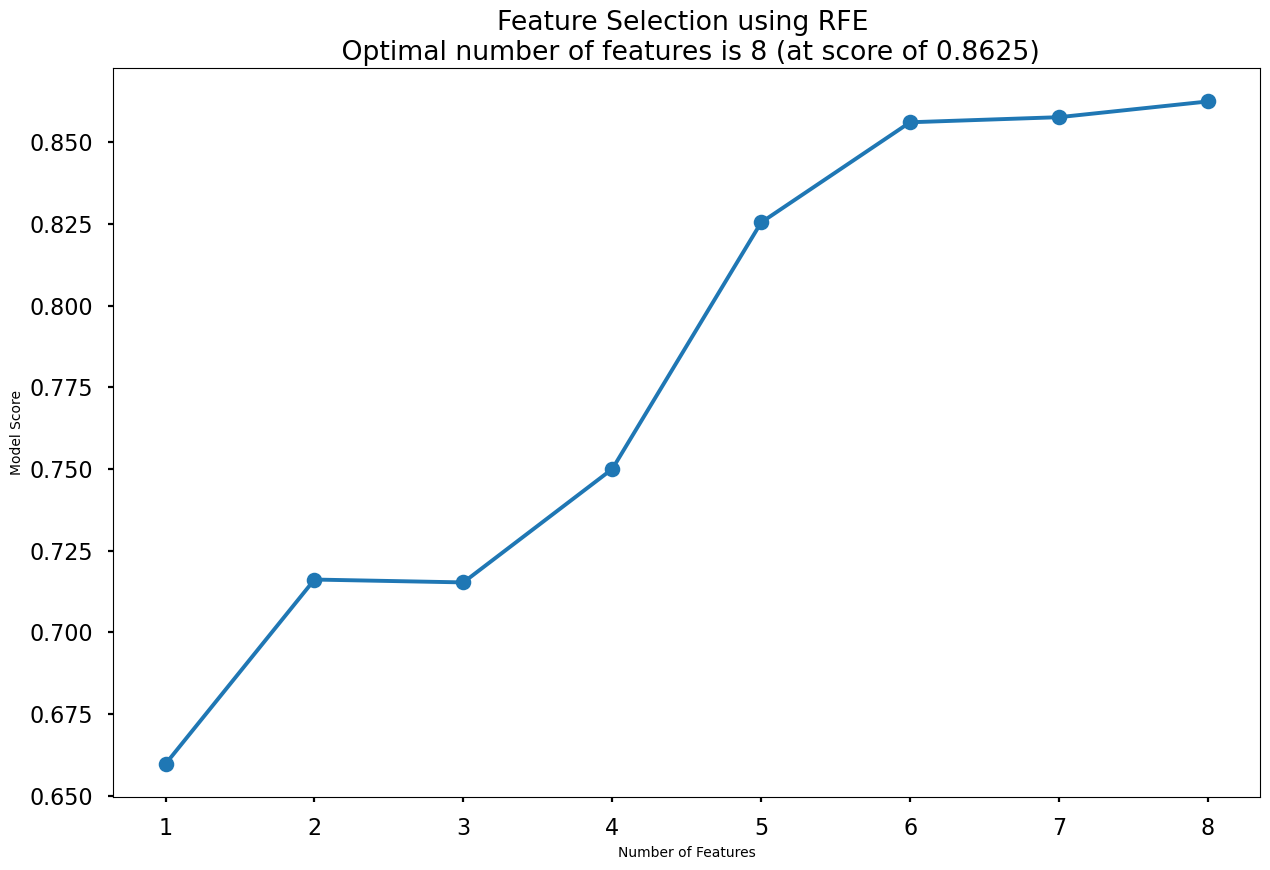

In [55]:
plt.style.use('seaborn-poster')
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

### Model Training

In [56]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [57]:
y_pred = regressor.predict(X_test)

In [58]:
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.7805702910327401


In [59]:
y_train_pred = regressor.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_train

0.8737966692767327

In [61]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)

cv_scores1 = cross_val_score(regressor,X_train,y_train,cv=cv,scoring="r2")

print(cv_scores1.mean())

0.8532327536589756


In [62]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1-r_squared)  * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.753563557621385


In [63]:
coefficients = pd.DataFrame(regressor.coef_)
input_variable_names = pd.DataFrame(X_train.columns)
summary_stats = pd.concat([input_variable_names, coefficients],axis=1)
print(summary_stats)

                      0         0
0   distance_from_store -0.201232
1          credit_score -0.027697
2           total_sales  0.000142
3           total_items  0.001002
4     transaction_count -0.004842
5    product_area_count  0.061659
6  average_basket_value -0.003971
7              gender_M -0.013393


## Decision Tree

In [64]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

In [65]:
# Importing the data stored as pickle file

data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_modelling.p', "rb"))
#rb = reading a file rather than writing 'wb' as writing as a file.


In [66]:
data_for_model.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [67]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 869
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             400 non-null    int64  
 1   distance_from_store     398 non-null    float64
 2   gender                  397 non-null    object 
 3   credit_score            398 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
 5   total_sales             400 non-null    float64
 6   total_items             400 non-null    int64  
 7   transaction_count       400 non-null    int64  
 8   product_area_count      400 non-null    int64  
 9   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 34.4+ KB


In [68]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [69]:
data_for_model.shape

(400, 9)

In [70]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [71]:
data_for_model.head(5)

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [72]:
data_for_model.dropna(how='any', inplace=True)

In [73]:
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [74]:
# In decision tree no need to remove outliers
# decision tree make split decisions based on the data either side of a line
# they don't really care how far away a point is interms of the distance
# so removing outliers won't change anything at all



In [75]:
# splitting input & output variable

X = data_for_model.drop('customer_loyalty_score',axis=1)
y = data_for_model['customer_loyalty_score']

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [77]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(315, 8)
(79, 8)
(315,)
(79,)


In [79]:
# decision tree still need data to be in numeric form

# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)

/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [81]:
# no need feature selection in decision tree


# in decision tree each variable is judged independently
# so if there is'nt any predictive power within an input variable , it will essentially be just be ignored anyway
# in saying this, even though it is not strictly required , it is'nt necessarly a bad thing to do feature selection
# and thus remove some features
# if you are in a situation that have high number of input variables, reducing this to a subset that are strongly linked to
# the output or target variable will mean much less computation is required
# training & prediction must be quicker
# to summarize applying feature selection won't make any difference to the performance of the decision tree
# in terms of accuracy, but it could help with performance in terms of computation
# since we are dealing with small number of input variables here we are going to remove this section of applying feature
# selection.

In [82]:
y_pred = regressor.predict(X_test)

In [83]:
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.8981805706349476


In [84]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)

cv_scores1 = cross_val_score(regressor,X_train,y_train,cv=cv,scoring="r2")

print(cv_scores1.mean())

0.8760266035577694


In [85]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1-r_squared)  * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.8865440644217988


In [86]:
# you remember in decision tree, the model learns the patterns of the data so precisely
# sometimes struggles to apply those rules on new data
# so lets add one more thing section where we are assessing the accuracy of the model
# and this to investigate level of overfitting 

y_train_pred = regressor.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_train

# means perfectly predicting on training set
# i much rather that our model was generalizing somewhat
# As if i apply this model to some other real world data.. then maybe it would'nt hold up so well
# it did predict pretty well on test set, so we are not seeing anything majorly going on
# but sometimes its nice to know that it could handle data that did'nt quite fit the exact mould of the
# training data, so we can add parameters in when we instantiate our model 
# which will limit its splitting
# we apply max_depth = we only allow to split certain number of times for its required to stop



1.0

In [87]:
max_depth_list = list(range(1,9))
accuracy_scores = []

for depth in max_depth_list:
    regressor = DecisionTreeRegressor(max_depth=depth,random_state=42)
    regressor.fit(X_train,y_train)
    
    y_pred=regressor.predict(X_test)
    accuracy=r2_score(y_test,y_pred)
    accuracy_scores.append(accuracy)

print(accuracy_scores)


[0.48041516747913704, 0.749628862008641, 0.8434993278383679, 0.8666832224200037, 0.8909700995376669, 0.8905579006885826, 0.8990238112614182, 0.8941316438857448]


In [88]:
max_accuracy=max(accuracy_scores)
max_accuracy_index=accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_index]

print(max_accuracy)
print(max_accuracy_index)
print(optimal_depth)

0.8990238112614182
6
7


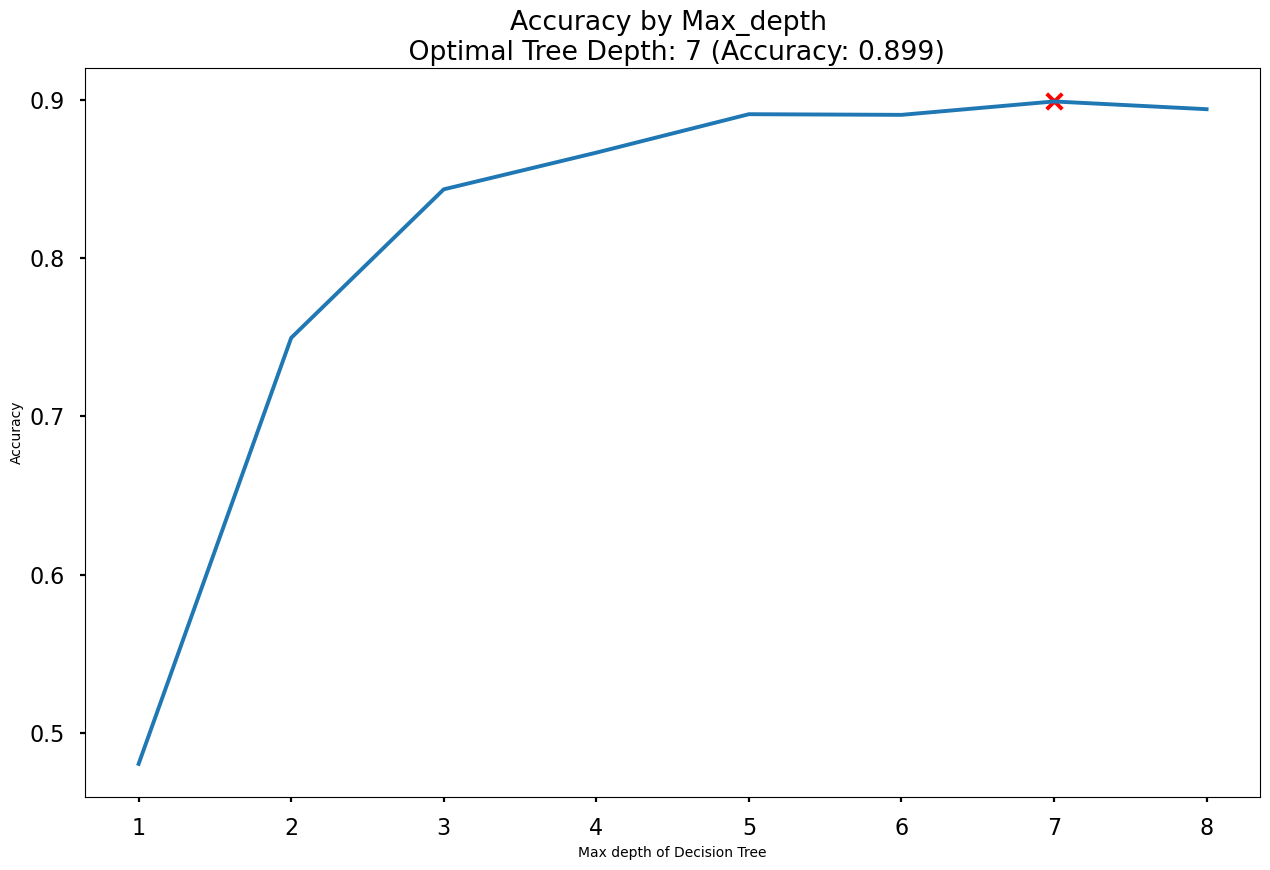

In [89]:
# plot of max_depths

plt.plot(max_depth_list,accuracy_scores)
plt.scatter(optimal_depth,max_accuracy,marker='x',color='red')
plt.title(f"Accuracy by Max_depth \n Optimal Tree Depth: {optimal_depth} (Accuracy: {round(max_accuracy,4)})")
plt.xlabel("Max depth of Decision Tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

Here we can see the accuracy over different max_depth that were applied and we can see
the optimal depth is at 'x' point which is 7 and i really want a good and also want a model that
will generalize well. so i'm gonna refit our model with max_depth of 4.. we might loose tiny bit of accuracy here
but would end up much simpler model to explain it to our stakeholders and it should also generalize really well on any new data that it receives.

**so lets re-fit our model with max depth of 4**

i've refitted the model with depth of 4 and it has accuracy of 0.86 rather than 0.89

In [90]:
regressor = DecisionTreeRegressor(max_depth=4,random_state=42)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [91]:
y_pred = regressor.predict(X_test)

In [92]:
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.8666832224200037


In [93]:

y_train_pred = regressor.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_train

0.9059473785182592

In [94]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1-r_squared)  * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.8514470192680041


In [95]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)

cv_scores1 = cross_val_score(regressor,X_train,y_train,cv=cv,scoring="r2")

print(cv_scores1.mean())

0.8046471635623549


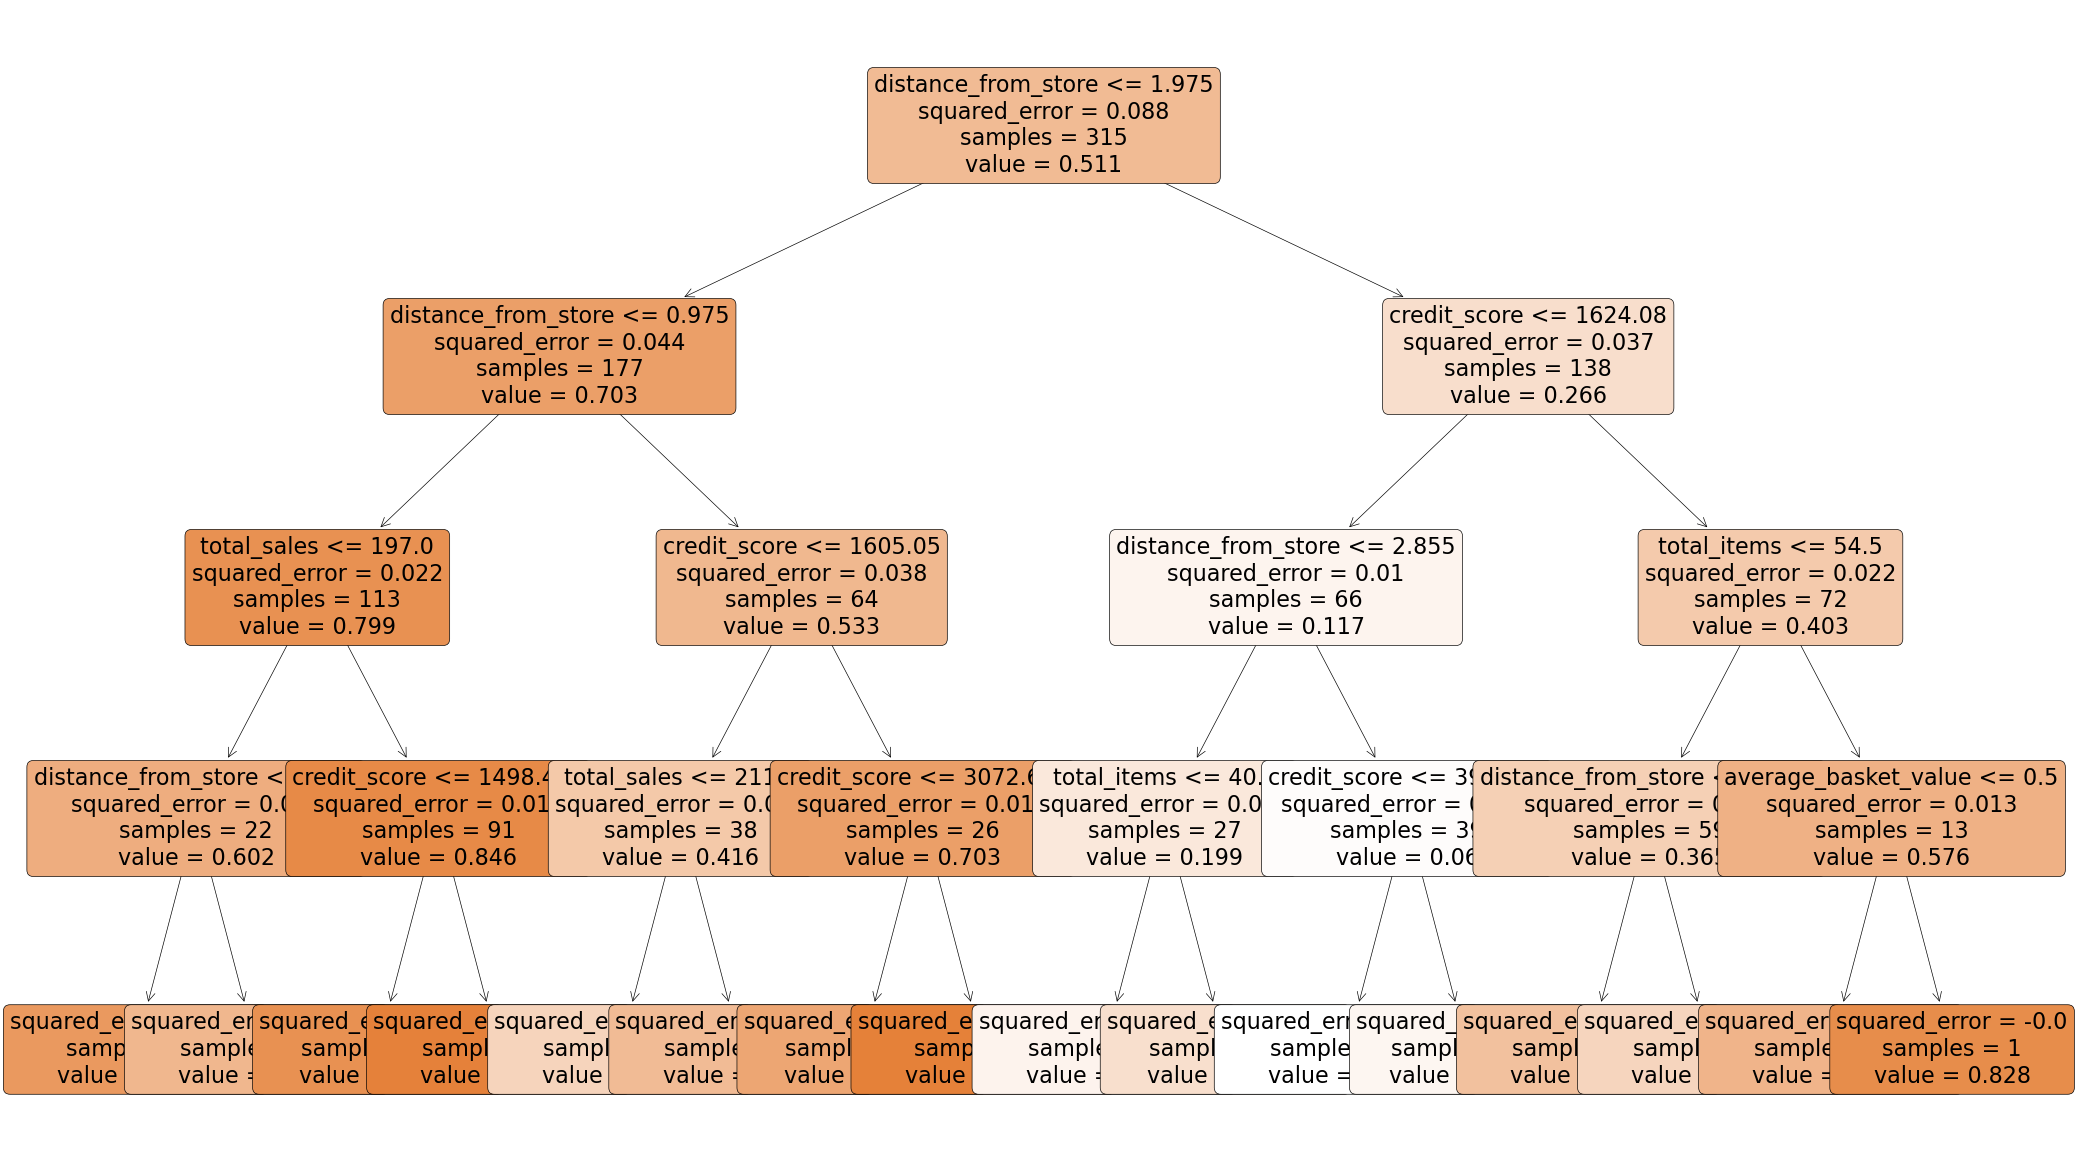

In [96]:
# lets plot our model
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(25,15))
tree = plot_tree(regressor, feature_names=X.columns,filled=True,rounded=True,fontsize=16)

**the first thing to see here is the "distance_from_store" is the first split.. so it is very important for 
loyalty score**


* I think we made big task of predicting loyalty_scores as you saw our decision tree was actually able to
  predict the loyalty scores better than linear regression with a really impressive r2 score of around 0.9
* In some cases they won't be able to generate the accuracy as other models as they are simplistic approaches
  but what they lack in predictive power can be made up for their "Interpretability" which can be so important
  when selling models in management & stakeholders

## Random Forest

In [99]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


# permutation feature importance and feature importance based on MSE gives simular results but
# permutation method is good for numerical features


In [102]:
# Importing the data stored as pickle file

data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_modelling.p', "rb"))
#rb = reading a file rather than writing 'wb' as writing as a file.


In [103]:
data_for_model.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [104]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 869
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             400 non-null    int64  
 1   distance_from_store     398 non-null    float64
 2   gender                  397 non-null    object 
 3   credit_score            398 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
 5   total_sales             400 non-null    float64
 6   total_items             400 non-null    int64  
 7   transaction_count       400 non-null    int64  
 8   product_area_count      400 non-null    int64  
 9   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 34.4+ KB


In [105]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [106]:
data_for_model.shape

(400, 9)

In [107]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [108]:
data_for_model.head(5)

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [109]:
data_for_model.dropna(how='any', inplace=True)

In [110]:
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [111]:
# In random forest just like decision tree, no need to remove outliers
# decision tree make split decisions based on the data either side of a line
# they don't really care how far away a point is interms of the distance
# so removing outliers won't change anything at all



In [112]:
# splitting input & output variable

X = data_for_model.drop('customer_loyalty_score',axis=1)
y = data_for_model['customer_loyalty_score']

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [114]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(315, 8)
(79, 8)
(315,)
(79,)


In [115]:
# decision tree still need data to be in numeric form

# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse_output=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first ( this is not so important in
# decision trees & random forest, it would'nt have added anything, so its best to remove them from the mix)

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)

In [116]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [117]:
# no need feature selection in decision tree


# in decision tree each variable is judged independently
# so if there is'nt any predictive power within an input variable , it will essentially be just be ignored anyway
# in saying this, even though it is not strictly required , it is'nt necessarly a bad thing to do feature selection
# and thus remove some features
# if you are in a situation that have high number of input variables, reducing this to a subset that are strongly linked to
# the output or target variable will mean much less computation is required
# training & prediction must be quicker
# to summarize applying feature selection won't make any difference to the performance of the decision tree
# in terms of accuracy, but it could help with performance in terms of computation
# since we are dealing with small number of input variables here we are going to remove this section of applying feature
# selection.

In [118]:
y_pred = regressor.predict(X_test)

In [119]:
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.9597164697184868


In [120]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)

cv_scores1 = cross_val_score(regressor,X_train,y_train,cv=cv,scoring="r2")

print(cv_scores1.mean())

0.9246701529836935


In [121]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1-r_squared)  * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.9551126376863138


        input_variables  Feature_importance
7  average_basket_value            0.009976
1                gender            0.010643
6    product_area_count            0.021630
4           total_items            0.025616
5     transaction_count            0.040695
3           total_sales            0.097355
2          credit_score            0.114349
0   distance_from_store            0.679737


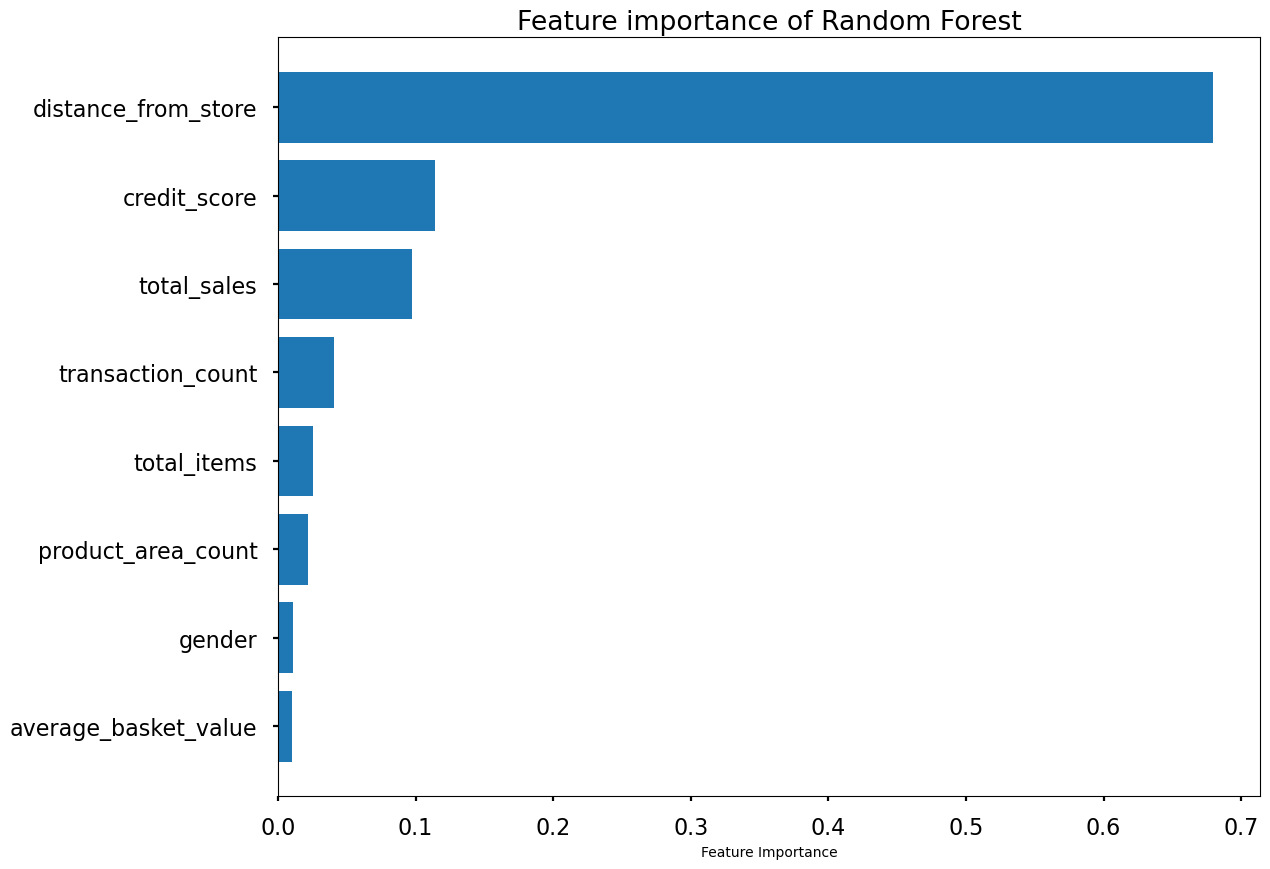

In [122]:
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],axis=1)
feature_importance_summary.columns=['input_variables','Feature_importance']
feature_importance_summary.sort_values(by='Feature_importance',inplace=True)
print(feature_importance_summary)

plt.barh(feature_importance_summary['input_variables'],feature_importance_summary['Feature_importance'])
plt.title('Feature importance of Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [123]:
# Permutation Importance

# The permutation feature importance is seen as decrease in model performance/accuracy when a particular input
# variables are randomly shuffled
# randomly shuffled destroys any relationship would have with the output variable and thus
# gives us a way to understand its importance as we can compare model performance with the shuffling 
# and with the values in their normal state 

# A large decrease in model performance when shuffled would indicate this as an input variable
# with high level of importance to our predictions and this approach is often preferred
# over standard feature importance method that we used above that measures the improvement of mean squared error
# as this can sometimes inflate the importance of numerical features

# but both methods are useful and in most cases will give fairly similar results


result = permutation_importance(regressor,X_test,y_test,n_repeats=10, random_state=42)
# n_repeat = specifies how many times we have to apply this random shuffling to each variable
print(result)

{'importances_mean': array([1.45768088e+00, 1.29671300e-03, 1.18107667e-01, 1.29106204e-01,
       1.72757386e-02, 4.41194645e-02, 8.23681639e-03, 3.96042348e-03]), 'importances_std': array([0.17995516, 0.00122933, 0.02189969, 0.00978422, 0.00389274,
       0.00939654, 0.00334001, 0.00149919]), 'importances': array([[ 1.35862917e+00,  1.33059164e+00,  1.23864655e+00,
         1.15335848e+00,  1.67358251e+00,  1.50436790e+00,
         1.70737763e+00,  1.49669816e+00,  1.44501318e+00,
         1.66854354e+00],
       [ 1.38422267e-03,  1.70503852e-03,  4.02139415e-04,
         1.62379599e-03,  6.55642681e-04,  3.74726835e-03,
        -1.24274775e-03,  1.85140706e-03,  2.06351899e-03,
         7.76844121e-04],
       [ 1.00859727e-01,  1.27053419e-01,  1.66911288e-01,
         1.19028511e-01,  1.29553654e-01,  1.02917347e-01,
         8.23240271e-02,  1.06490138e-01,  1.12689637e-01,
         1.33248922e-01],
       [ 1.17203175e-01,  1.41081697e-01,  1.28853522e-01,
         1.25055805e-

        input_variables  permutation_importance
1                gender                0.001297
7  average_basket_value                0.003960
6    product_area_count                0.008237
4           total_items                0.017276
5     transaction_count                0.044119
2          credit_score                0.118108
3           total_sales                0.129106
0   distance_from_store                1.457681


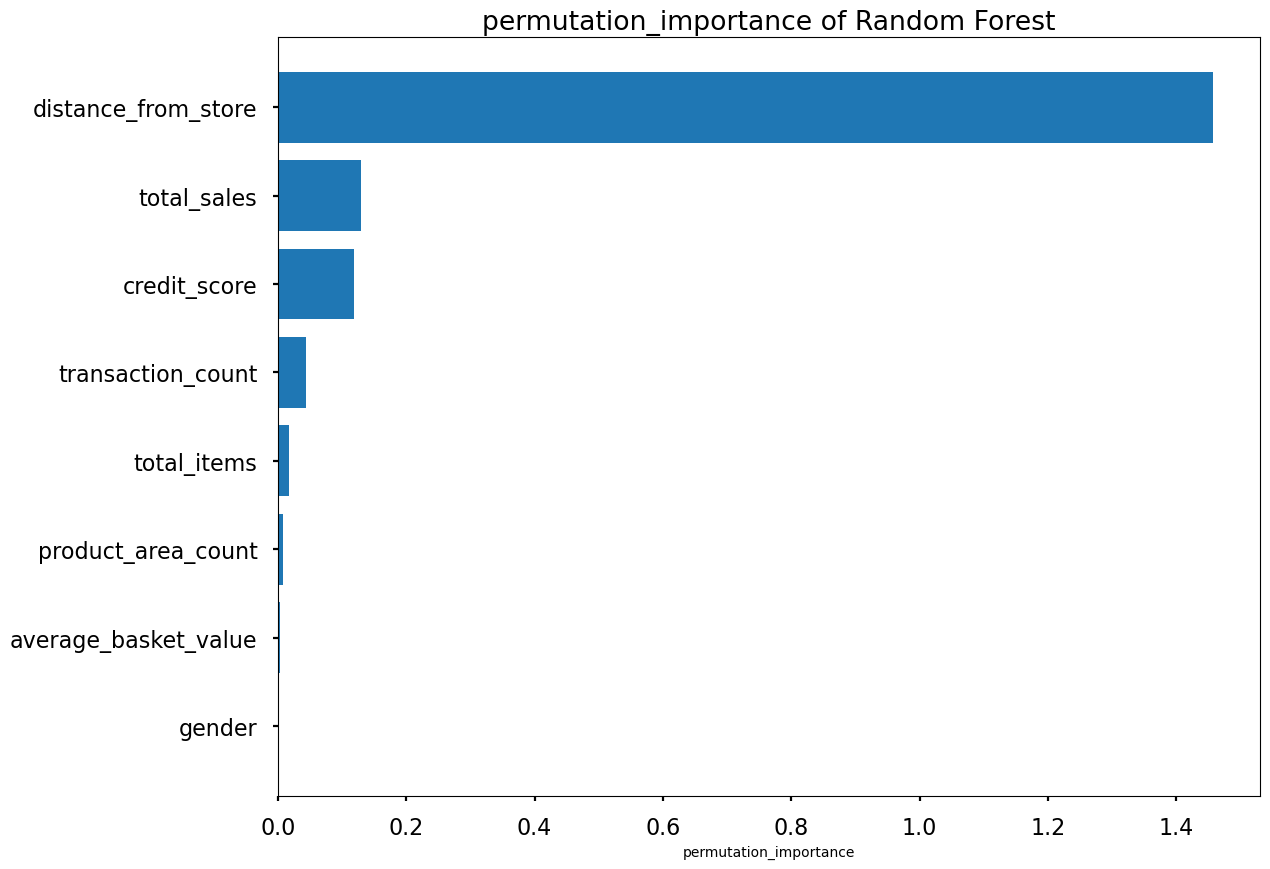

In [124]:
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],axis=1)
permutation_importance_summary.columns=['input_variables','permutation_importance']
permutation_importance_summary.sort_values(by='permutation_importance',inplace=True)
print(permutation_importance_summary)

plt.barh(permutation_importance_summary['input_variables'],permutation_importance_summary['permutation_importance'])
plt.title('permutation_importance of Random Forest')
plt.xlabel('permutation_importance')
plt.tight_layout()
plt.show()

In [126]:
# the differences are not major, there are couple of swaps of position i.e credit_score & total_sales are swapped
# its kind of interesting that distance from store in this approach is proportionally more important than it did
# in the first approach

# as i said both are methods are useful , the results are fairly similar
# what we are really after is way to understand what is driving the predictions in our model, 
# i think both ways offer up pretty similar narrative

# in general permutation approach is slightly superior approach , if you want to go with one of 
# approaches, then permutation you can choose

# Just remember to explain exactly how it works to the stakeholders so they understand it and they
# will be comfortable moving forward.


In [127]:
# predictions under the hood

print(y_pred[0])
new_data = [X_test.iloc[0]]
print(new_data)


0.2267300000000002
[distance_from_store        2.270000
credit_score               0.490000
total_sales             1506.490000
total_items              281.000000
transaction_count         47.000000
product_area_count         3.000000
average_basket_value      32.052979
gender_M                   0.000000
Name: 0, dtype: float64]


In [128]:
regressor.estimators_ # these are the decision trees present under the hood of random forest

[DecisionTreeRegressor(max_features=1.0, random_state=1608637542),
 DecisionTreeRegressor(max_features=1.0, random_state=1273642419),
 DecisionTreeRegressor(max_features=1.0, random_state=1935803228),
 DecisionTreeRegressor(max_features=1.0, random_state=787846414),
 DecisionTreeRegressor(max_features=1.0, random_state=996406378),
 DecisionTreeRegressor(max_features=1.0, random_state=1201263687),
 DecisionTreeRegressor(max_features=1.0, random_state=423734972),
 DecisionTreeRegressor(max_features=1.0, random_state=415968276),
 DecisionTreeRegressor(max_features=1.0, random_state=670094950),
 DecisionTreeRegressor(max_features=1.0, random_state=1914837113),
 DecisionTreeRegressor(max_features=1.0, random_state=669991378),
 DecisionTreeRegressor(max_features=1.0, random_state=429389014),
 DecisionTreeRegressor(max_features=1.0, random_state=249467210),
 DecisionTreeRegressor(max_features=1.0, random_state=1972458954),
 DecisionTreeRegressor(max_features=1.0, random_state=1572714583),
 De

In [129]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction=tree.predict(new_data)[0]
    predictions.append(prediction)
    tree_count+=1

print(predictions) # shows 100 predictions for this customer from each decision tree of random forest

print(sum(predictions)/len(predictions)) # we see its exactly same

[0.201, 0.668, 0.117, 0.17, 0.203, 0.268, 0.17, 0.203, 0.23400000000000004, 0.17, 0.234, 0.12, 0.234, 0.174, 0.147, 0.352, 0.268, 0.234, 0.234, 0.234, 0.203, 0.17400000000000002, 0.17, 0.234, 0.177, 0.12, 0.314, 0.174, 0.234, 0.302, 0.352, 0.314, 0.234, 0.174, 0.116, 0.221, 0.201, 0.177, 0.203, 0.147, 0.12, 0.234, 0.234, 0.201, 0.203, 0.221, 0.203, 0.366, 0.201, 0.334, 0.366, 0.17, 0.448, 0.12, 0.234, 0.136, 0.23400000000000004, 0.17, 0.174, 0.201, 0.147, 0.201, 0.366, 0.344, 0.221, 0.17400000000000002, 0.234, 0.177, 0.17, 0.12, 0.42, 0.344, 0.12, 0.221, 0.17, 0.234, 0.17, 0.203, 0.234, 0.234, 0.314, 0.234, 0.234, 0.143, 0.17, 0.234, 0.201, 0.12, 0.174, 0.17, 0.35200000000000004, 0.234, 0.174, 0.506, 0.177, 0.352, 0.352, 0.147, 0.234, 0.201]
0.2267300000000002


In [130]:
print(y_pred[0])

0.2267300000000002


In [131]:
import pickle

pickle.dump(regressor,open("/Users/praju/Desktop/DSI/Untitled Folder/CLP/random_forest_regression_model.p",'wb'))
pickle.dump(one_hot_encoder,open("/Users/praju/Desktop/DSI/Untitled Folder/CLP/random_forest_regression_ohe.p",'wb'))

## Modelling Summary

The most important outcome for this project was predictive accuracy, rather than explicitly understanding the drivers of prediction. Based upon this, we chose the model that performed the best when predicted on the test set - the Random Forest.


Metric 1: Adjusted R-Squared (Test Set)

* Random Forest = 0.955
* Decision Tree = 0.886
* Linear Regression = 0.754

Metric 2: R-Squared (K-Fold Cross Validation, k = 4)

* Random Forest = 0.925
* Decision Tree = 0.871
* Linear Regression = 0.853

Even though we were not specifically interested in the drivers of prediction, it was interesting to see across all three modelling approaches, that the input variable with the biggest impact on the prediction was distance_from_store rather than variables such as total sales. This is interesting information for the business, so discovering this as we went was worthwhile.

## Predicting Missing Loyalty Scores

In [132]:
# import required packages
import pandas as pd
import pickle

In [133]:
# import customers for scoring
to_be_scored = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/abc_regression_scoring.p', "rb"))

# import model and model objects
regressor = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/random_forest_regression_model.p', "rb"))
one_hot_encoder = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/CLP/random_forest_regression_ohe.p', "rb"))



In [134]:
to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470 entries, 6 to 867
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           470 non-null    int64  
 1   distance_from_store   467 non-null    float64
 2   gender                468 non-null    object 
 3   credit_score          464 non-null    float64
 4   total_sales           470 non-null    float64
 5   total_items           470 non-null    int64  
 6   transaction_count     470 non-null    int64  
 7   product_area_count    470 non-null    int64  
 8   average_basket_value  470 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 36.7+ KB


In [135]:
# drop unused columns
to_be_scored.drop(["customer_id"], axis = 1, inplace = True)

# drop missing values
to_be_scored.dropna(how = "any", inplace = True)

# apply one hot encoding (transform only)
categorical_vars = ["gender"]
encoder_vars_array = one_hot_encoder.transform(to_be_scored[categorical_vars])
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)
to_be_scored = pd.concat([to_be_scored.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)
to_be_scored.drop(categorical_vars, axis = 1, inplace = True)

# make our predictions!
loyalty_predictions = regressor.predict(to_be_scored)

The loyalty scores for the missing **463 customers** were found to be [0.42696, 0.33022, 0.34719, 0.93087, 0.38542………..0.89533, 0.95938, 0.71815, 0.36844, 0.93004, 0.68015, 0.37042,0.61175]


Just like that, we have made our loyalty_score predictions for these missing customers. Due to the impressive metrics on the test set, we can be reasonably confident with these scores. This extra customer information will ensure our client can undertake more accurate and relevant customer tracking, targeting, and comms.